## Face Emotion Detection

The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centered and occupies about the same amount of space in each image. The task is to categorize each face based on the emotion shown in the facial expression in to one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).

For our model we will be considering only the distinct Emotions which are (0=Angry, 3=Happy, 4=Sad, 5=Surprise)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv('./fer2013.csv')

### Data exploration and preparation 

In [3]:
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [4]:
df.info()
print(len(df))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB
35887


In [5]:
df['Usage'].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [6]:
# splitting dataset into training and testing 
train_data = df[df["Usage"] == "Training"]
public_test = df[df["Usage"] == "PublicTest"]
public_test = public_test.reset_index()
private_test = df[df["Usage"] == "PrivateTest"]

In [7]:
df['emotion'].value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [8]:
emotion_dict = { 0:"Angry", 3:"Happy", 4:"Sad", 5:"Surprise"}

In [9]:
# selecting requried emotions
train_data = train_data[(train_data["emotion"]==0) | (train_data["emotion"]==3) | (train_data["emotion"]==4) | (train_data["emotion"]==5) ]
train_data = train_data.reset_index()

In [10]:
def display_pic_with_emotion(raw_pixels,emotion,emotion_dict):
    img = raw_pixels
    val = img.split(" ")
    pixels = np.array(val, 'float32')
    pixels /= 255
    
    x_reshaped = pixels.reshape(48,48)
    plt.imshow(x_reshaped, cmap= "gray",
              interpolation="nearest")
    plt.axis("off")
    plt.show()
    print(emotion_dict.get(emotion))

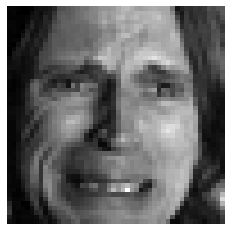

Sad


In [11]:
# testing function
n=9213
display_pic_with_emotion(df['pixels'][n],df["emotion"][n],emotion_dict)

In [12]:
# data conversion and reshaping
X=[]
n=len(train_data)
#for i in range(0,len(train_data)):

for i in range(0,n):    
    img = train_data['pixels'][i]
    val = img.split(" ")
    pixels = np.array(val, 'float')
    pixels /=255
    X.append(pixels.reshape(48,48))
    
X = np.array(X)
X = X.reshape(X.shape[0],X.shape[1],X.shape[2],1)

In [13]:
Y = train_data['emotion'][0:n]
Y = np.array(Y)

In [14]:
Y.shape

(19211,)

### Modelling and Evaluation

In [15]:
import tensorflow as tf
from tensorflow.keras import backend
backend.clear_session()

from tensorflow.keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose,MaxPool2D,MaxPooling2D
from tensorflow.keras.layers import Activation, Dense, Dropout, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.model_selection import KFold

In [16]:
#building convoluted network
# Define the K-fold Cross Validator
kfold = KFold(n_splits=2, shuffle=True)

#k-fold initialize
fold_no = 1

#Initialize CNN
for train, test in kfold.split(X, Y):
    cnn = Sequential([
        layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1),padding='same'),
        layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu',padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.5),
    
        layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu',padding='same'),
        layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu',padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.5),
        
        layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu',padding='same'),
        layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu',padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.5),
    
    
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(7, activation='softmax')
    ])
    
    cnn.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    cnn.summary()
    
    #fit model
    cnn.fit(X[train], Y[train], epochs=10)
    
    #evaluate model
    cnn.evaluate(X[test],Y[test])
    
    fold_no = fold_no + 1

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 128)       0

### Testing - public dataset

In [17]:
public_test = public_test[(public_test["emotion"]==0) | (public_test["emotion"]==3) | (public_test["emotion"]==4) | (public_test["emotion"]==5) ]
public_test = public_test.reset_index()
public_test.head()

,level_0,index,emotion,pixels,Usage
0,0,28709,0,254 254 254 254 254 249 255 160 2 58 53 70 77 ...,PublicTest
1,2,28711,4,69 118 61 60 96 121 103 87 103 88 70 90 115 12...,PublicTest
2,4,28713,3,87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...,PublicTest
3,5,28714,3,235 233 223 109 34 37 34 31 28 38 56 69 106 13...,PublicTest
4,7,28716,0,176 177 170 168 173 171 167 169 166 139 98 107...,PublicTest


In [18]:
n=len(public_test)
X_test=[]
Y_test=[]

for i in range(0,n):    
    img = public_test['pixels'][i]
    val = img.split(" ")
    pixels = np.array(val, 'float')
    pixels /=255
    X_test.append(pixels.reshape(48,48))
    
X_test = np.array(X_test)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],1)

Y_test = public_test['emotion'][0:n]
Y_test = np.array(Y_test)

In [19]:
y_pred = cnn.predict(X_test)

In [20]:
y_pred[:5]

array([[4.26332980e-01, 4.64098378e-07, 1.10833454e-07, 1.35399476e-01,
        4.14913118e-01, 2.33536903e-02, 1.82842939e-07],
       [3.81589770e-01, 2.42829674e-06, 4.72980105e-07, 1.27941417e-02,
        5.70664525e-01, 3.49469371e-02, 1.72372586e-06],
       [7.93764368e-03, 3.52311652e-11, 8.51169690e-11, 9.88796353e-01,
        1.72299123e-03, 1.54305727e-03, 7.79632303e-10],
       [4.28495789e-03, 1.38789397e-10, 3.84790338e-10, 9.79614437e-01,
        4.31255065e-03, 1.17880860e-02, 1.63686853e-09],
       [1.51198491e-01, 1.74091037e-05, 6.14425835e-06, 1.04877032e-01,
        6.97360456e-01, 4.65310402e-02, 9.38271660e-06]], dtype=float32)

In [21]:
y_classes = [np.argmax(element) for element in y_pred]
y_classes[:10]

[0, 4, 3, 3, 4, 5, 3, 0, 4, 5]

In [22]:
Y_test[:10]

array([0, 4, 3, 3, 0, 0, 3, 0, 4, 5], dtype=int64)

In [23]:
from sklearn.metrics import confusion_matrix , classification_report
print("Classification Report: \n", classification_report(Y_test, y_classes))

Classification Report: 
               precision    recall  f1-score   support

           0       0.68      0.34      0.45       467
           3       0.77      0.86      0.82       895
           4       0.59      0.74      0.65       653
           5       0.81      0.74      0.77       415

    accuracy                           0.71      2430
   macro avg       0.71      0.67      0.67      2430
weighted avg       0.71      0.71      0.69      2430



### Testing - private dataset

In [24]:
private_test = private_test[(private_test["emotion"]==0) | (private_test["emotion"]==3) | (private_test["emotion"]==4) | (private_test["emotion"]==5) ]
private_test = private_test.reset_index()
private_test.head()

,index,emotion,pixels,Usage
0,32298,0,170 118 101 88 88 75 78 82 66 74 68 59 63 64 6...,PrivateTest
1,32299,5,7 5 8 6 7 3 2 6 5 4 4 5 7 5 5 5 6 7 7 7 10 10 ...,PrivateTest
2,32301,4,200 197 149 139 156 89 111 58 62 95 113 117 11...,PrivateTest
3,32303,0,138 142 66 80 87 92 97 99 88 73 72 83 92 102 1...,PrivateTest
4,32304,4,72 66 66 69 62 51 57 60 56 66 63 70 68 68 81 9...,PrivateTest


In [25]:
n=len(private_test)
X_ptest=[]
Y_ptest=[]

for i in range(0,n):    
    img = private_test['pixels'][i]
    val = img.split(" ")
    pixels = np.array(val, 'float')
    pixels /=255
    X_ptest.append(pixels.reshape(48,48))
    
X_ptest = np.array(X_ptest)
X_ptest = X_ptest.reshape(X_ptest.shape[0],X_ptest.shape[1],X_ptest.shape[2],1)

Y_ptest = private_test['emotion'][0:n]
Y_ptest = np.array(Y_ptest)

In [26]:
y_pred = cnn.predict(X_ptest)
y_classes = [np.argmax(element) for element in y_pred]
print("Classification Report: \n", classification_report(Y_ptest, y_classes))

Classification Report: 
               precision    recall  f1-score   support

           0       0.67      0.30      0.42       491
           3       0.73      0.87      0.80       879
           4       0.53      0.69      0.60       594
           5       0.84      0.69      0.76       416

    accuracy                           0.68      2380
   macro avg       0.69      0.64      0.64      2380
weighted avg       0.69      0.68      0.66      2380



### Result

The overall accuracy of the model is around 70%.